# Perform submodular optimization to identify portfolio

## Import modules

In [1]:
import openml
import numpy as np
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from utils.functions_best_setups import sub_opt, perf_imp


# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

## Get HGB evaluation matrix

In [2]:
# get HGB evals
evals_hgb = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736],
                                            output_format='dataframe')

evals_hgb.shape

(35708, 12)

In [3]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_hgb.setup_id.value_counts()).index[(evals_hgb.setup_id.value_counts() >= 68)]
evals_subset_hgb = evals_hgb[evals_hgb.setup_id.isin(ids)]

# transform to wide format
evals_wide_hgb = evals_subset_hgb.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')


In [10]:
evals_wide_hgb

task_id,3,6,11,12,14,15,16,18,22,23,...,146821,146822,146824,146825,167119,167120,167124,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153803,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,0.897453,0.982444,0.994517,0.923335
8153818,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.999998,0.995578,0.998918,0.970201,0.976242,0.522143,NaN,0.982444,0.994517,0.923335
8154107,0.989010,0.991119,0.961261,0.998322,0.979694,0.991484,0.996002,0.961062,0.974849,0.747092,...,0.993265,0.992311,0.997885,0.985661,0.923098,0.528767,NaN,0.944920,0.993895,0.913378
8154115,0.910643,0.500008,0.604674,0.500000,0.500000,0.525230,0.500000,0.500000,0.500000,0.507958,...,0.500277,0.500000,0.500000,0.655196,0.500000,0.513842,0.709518,0.500327,0.499731,0.732339


## Get SVC evaluation matrix

### Get evaluations

In [147]:
# get HGB evals
evals_svc = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345, 16366], 
                                            output_format='dataframe')



In [5]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 146821, 167125, 167140, 3573]
evals_mixed_svc = evals_svc[evals_svc.task_id.isin(mixed_tasks)]
evals_mixed_svc.shape
len(evals_mixed_svc.setup_id.unique())

12270

In [6]:
# get evals of pure tasks
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 40)]
evals_pure_svc = evals_svc[evals_svc.setup_id.isin(ids)]
evals_pure_svc.shape
len(evals_pure_svc.setup_id.unique())

326

### Get setups

In [10]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_svc.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape',
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state',
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_svc.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [11]:
# get setups of pure tasks
setup_info_names = ['setup_id']
param_names = list(openml.setups.initialize_model(8231383).steps[2][1].get_params().keys())

setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_svc.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [12]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']
id_match = pd.DataFrame(columns= ['setup_id_mixed', 'setup_id'])

for i in range(len(setups_mixed)):
    print(i, end='\r')
    for j in range(len(setups_pure)):
        if all(setups_mixed.loc[i][param_keys] == setups_pure.loc[j][param_keys]): 
            id_match.loc[len(id_match)] = (setups_mixed.loc[i]['setup_id'], setups_pure.loc[j]['setup_id'])

In [13]:
# reassign setup_ids
evals_mixed_final = pd.DataFrame(columns = ['run_id', 'task_id', 'setup_id', 'flow_id', 'flow_name', 'data_id',
                       'data_name', 'function', 'upload_time', 'value', 'values',
                        'array_data'])

for i in id_match.iterrows():
    try:
        x = evals_mixed_svc[evals_mixed_svc.setup_id == i[1][0]]
        x.iat[0,2] = i[1][1]
        evals_mixed_final.loc[len(evals_mixed_final)] = list(x.values[0])
    except:
        print('', end ='')
    

### Recreate evaluation matrix with matched setups

In [14]:
# merge pure and mixed setups
evals_svc = evals_pure_svc.append(evals_mixed_final)

In [15]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 2)]
evals_subset_svc = evals_svc[evals_svc.setup_id.isin(ids)]

# transform to wide format
evals_wide_svc = evals_subset_svc.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [16]:
evals_wide_svc

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8231564,0.997192,0.983414,1.000000,0.975833,0.904444,0.930557,0.986389,0.861389,0.893889,0.620403,...,0.825691,0.772487,0.935748,0.998069,0.955556,0.932500,0.865297,NaN,0.963584,0.787323
8231566,0.916670,0.947929,0.842717,0.509444,0.513333,0.959716,0.511389,0.825278,0.536667,0.580964,...,0.673540,0.500000,0.891696,0.500000,0.939141,0.506389,0.824379,NaN,0.595094,0.500000
8231570,0.743942,0.924207,0.838377,0.508889,0.510556,0.957424,0.510833,0.846111,0.522222,0.575136,...,0.655898,0.500000,0.887805,0.500000,0.940657,0.530833,0.838645,NaN,0.595094,0.500000
8231572,0.589718,0.912946,0.835409,0.508333,0.509167,0.957424,0.509722,0.817222,0.520278,0.571012,...,0.648225,0.500000,0.877026,0.500000,0.935606,0.578889,0.824462,NaN,0.595094,0.500000
8231574,0.930534,0.949465,0.842465,0.509444,0.513333,0.959716,0.511389,0.828889,0.537500,0.579402,...,0.676695,0.500000,0.891587,0.500000,0.938889,0.506389,0.826300,NaN,0.595094,0.500000
8231579,0.956269,0.968939,0.892972,0.511667,0.517778,0.963100,0.514167,0.846111,0.583611,0.580295,...,0.718558,0.500000,0.899191,0.897090,0.946465,0.508056,0.851318,NaN,0.595094,0.500000
8231582,0.996811,0.969221,0.957053,0.982778,0.861944,0.893212,0.969722,0.851667,NaN,0.577411,...,0.813721,0.580884,0.928581,1.000000,0.951768,0.982778,0.877094,NaN,0.969548,0.742362
8231585,0.996238,0.985649,0.967550,0.957222,0.887778,0.950429,0.980833,0.860556,NaN,0.642317,...,0.845374,0.751760,0.917574,0.995219,0.950000,0.862222,0.848400,NaN,0.810424,0.819712
8231589,0.994113,0.981879,0.950392,0.968056,0.901389,0.968119,0.985000,0.857500,0.895278,0.654468,...,0.846626,0.749736,0.875538,0.983049,0.945707,0.906111,0.831092,NaN,0.947374,0.825910


In [146]:
evals_wide_svc[3]

setup_id
8231564    0.997192
8231566    0.916670
8231570    0.743942
8231572    0.589718
8231574    0.930534
8231579    0.956269
8231582    0.996811
8231585    0.996238
8231589    0.994113
8231591    0.997192
8231594    0.997220
8231597    0.996294
8231599    0.996865
8231603    0.995395
8231606    0.994440
8231609    0.997520
8231611    0.949908
8231614    0.995040
8231617    0.982506
8231620    0.993758
8231623    0.980681
8231625    0.582243
8231628    0.991849
8231631    0.988414
8231634    0.994385
8231637    0.938720
8231640    0.995283
8231642    0.957990
8231645    0.967437
8231648    0.911646
             ...   
8232338    0.939702
8232340    0.966775
8232342    0.941339
8232344    0.947240
8232345    0.970042
8232347    0.994984
8232348    0.997520
8232350    0.916948
8232352    0.996893
8232354    0.995311
8232356    0.995611
8232358    0.996266
8232360    0.975309
8232361    0.970871
8232363    0.972669
8232365    0.390927
8232367    0.997192
8232369    0.992803
8232371    

## Merge HGB and SVC data 

In [14]:
# evals_wide_merged = pd.concat([evals_wide_hgb, evals_wide_svc])
evals_wide_merged = evals_wide_hgb
evals_wide_merged = evals_wide_merged.drop([3573, 146825, 167124], axis = 1)

In [15]:
evals_wide_merged

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153803,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153818,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8154107,0.989010,0.991119,0.961261,0.998322,0.979694,0.991484,0.996002,0.961062,0.974849,0.747092,...,0.935421,0.986838,0.993265,0.992311,0.997885,0.923098,0.528767,0.944920,0.993895,0.913378
8154115,0.910643,0.500008,0.604674,0.500000,0.500000,0.525230,0.500000,0.500000,0.500000,0.507958,...,0.500805,0.500000,0.500277,0.500000,0.500000,0.500000,0.513842,0.500327,0.499731,0.732339


In [16]:
x = evals_wide_merged.isna().sum()
x.loc[x>0]

Series([], dtype: int64)

## Submodular optimization AUC (min-max scaled, mean)

In [17]:
# normalize evaluation metrics within tasks
evals_wide_merged_norm = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_wide_merged), 
                               index= evals_wide_merged.index,
                               columns = evals_wide_merged.columns)

In [18]:
evals_wide_merged_norm_clean = evals_wide_merged_norm.fillna(0)

In [19]:
order_setups = np.argsort(evals_wide_merged_norm.mean(axis = 1))
order_tasks = np.argsort(evals_wide_merged_norm.mean(axis = 0))
evals_wide_merged_norm_ordered = evals_wide_merged_norm.iloc[order_setups, order_tasks]

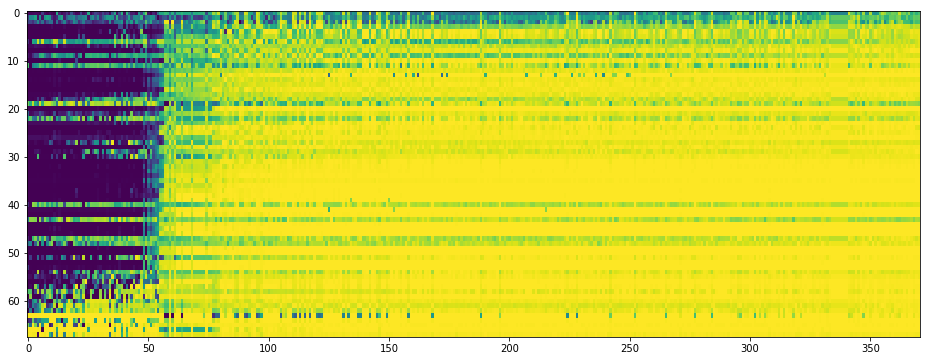

In [20]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_merged_norm_ordered.T, aspect = 'auto')

In [21]:
evals_wide_merged_norm.shape

(371, 68)

In [22]:
order_setups = np.argsort(evals_wide_merged_norm_clean.mean(axis = 1))
order_tasks = np.argsort(evals_wide_merged_norm_clean.mean(axis = 0))

evals_wide_merged_norm_clean_ordered = evals_wide_merged_norm_clean.iloc[order_setups, order_tasks]

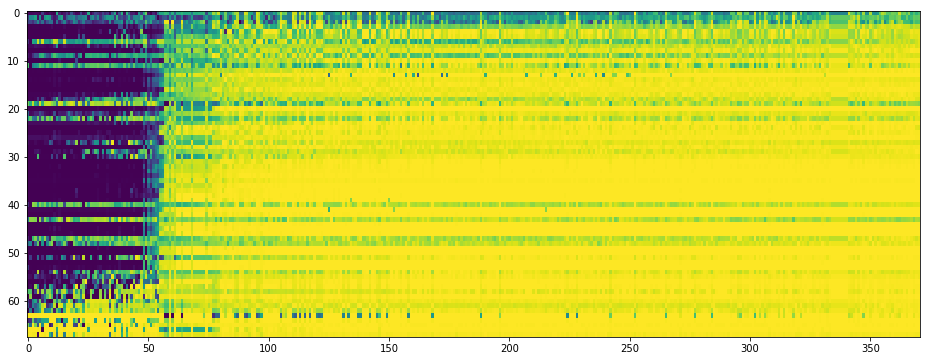

In [23]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_merged_norm_clean_ordered.T, aspect = 'auto')

## Plot performance improvement for each additional classifier

In [24]:
setup_id, portfolio_performance = perf_imp(evals_wide_merged_norm_clean)

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

''

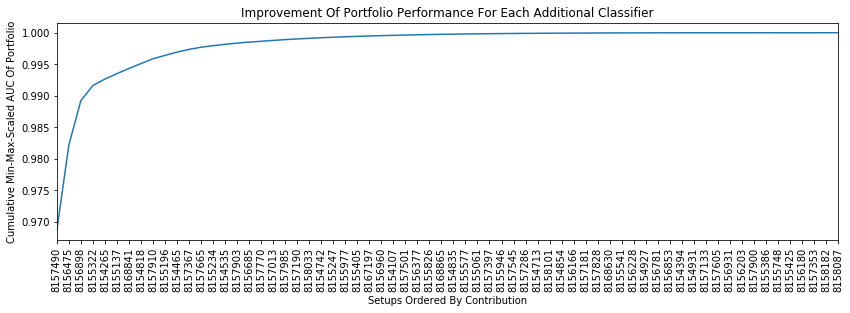

In [25]:
ax = pd.Series(portfolio_performance).plot(figsize = (14,4), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_ylabel('Cumulative Min-Max-Scaled AUC Of Portfolio')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

''

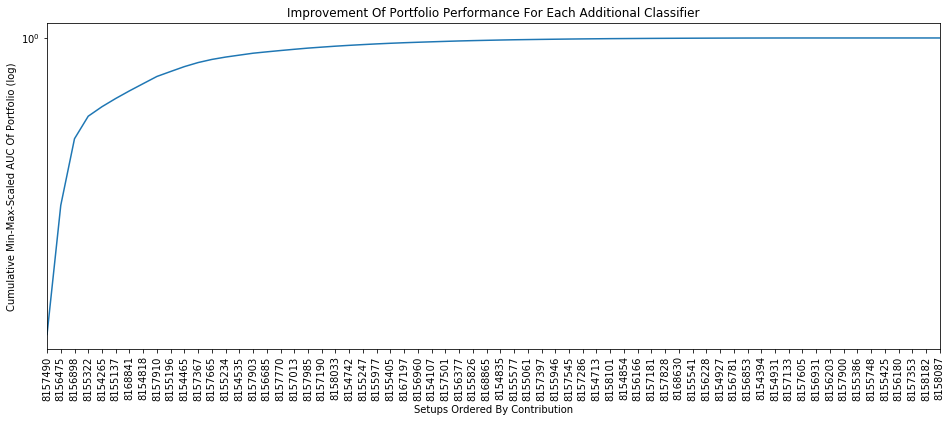

In [26]:
ax = pd.Series(portfolio_performance).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_yscale('log')
ax.set_ylabel('Cumulative Min-Max-Scaled AUC Of Portfolio (log)')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

In [27]:
pp_neg = [1-i for i in portfolio_performance]

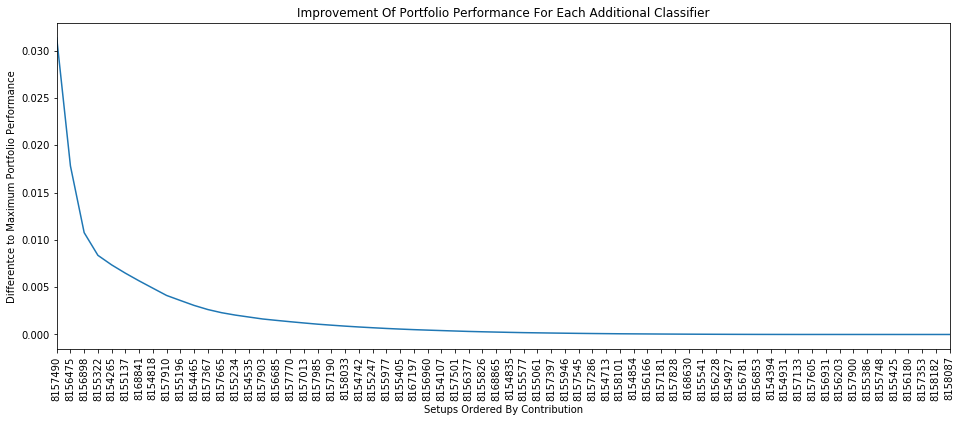

In [28]:
ax = pd.Series(pp_neg).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_ylabel('Differentce to Maximum Portfolio Performance')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier');


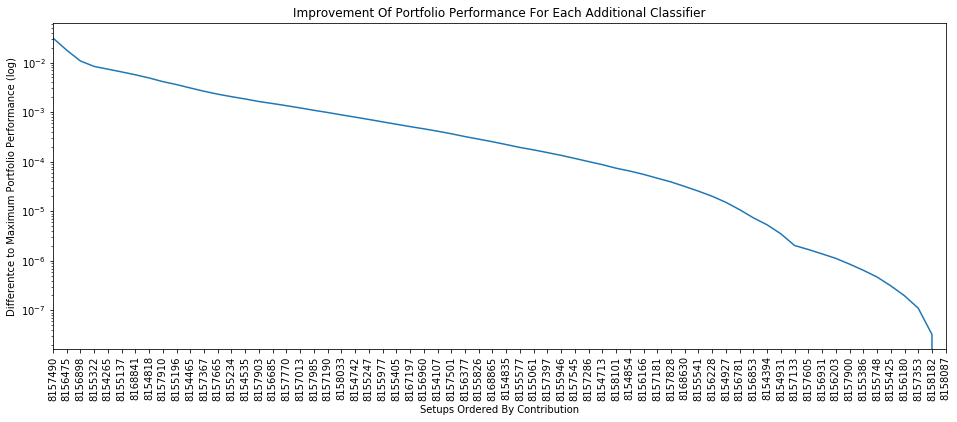

In [29]:
ax = pd.Series(pp_neg).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_yscale('log')
ax.set_ylabel('Differentce to Maximum Portfolio Performance (log)')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier');


In [30]:
# get ensemble of 10 setups
setup_list_auc = sub_opt(evals_wide_merged_norm_clean, 31)
setup_list_auc

[8157490,
 8156475,
 8156898,
 8155322,
 8154265,
 8155137,
 8168841,
 8154818,
 8157910,
 8155196,
 8154465,
 8157367,
 8157665,
 8155234,
 8154535,
 8157903,
 8156685,
 8157770,
 8157013,
 8157985,
 8157190,
 8158033,
 8154742,
 8155247,
 8155977,
 8155405,
 8167197,
 8156960,
 8154107,
 8157501,
 8156377,
 8155826]

In [33]:
len(setup_list_auc)

32

## Get model condigurations

In [38]:
counter = 1
for i in setup_list_auc:

    print(str(counter)+')', openml.setups.initialize_model(i)[-1], ',')
    print()
    counter += 1

1) HistGradientBoostingClassifier(l2_regularization=1e-08, learning_rate=0.01,
                               loss='auto', max_bins=128, max_depth=19,
                               max_iter=500, max_leaf_nodes=128,
                               min_samples_leaf=38, n_iter_no_change=None,
                               random_state=31537, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0) ,

2) HistGradientBoostingClassifier(l2_regularization=1e-10, learning_rate=0.1,
                               loss='auto', max_bins=64, max_depth=2,
                               max_iter=100, max_leaf_nodes=4,
                               min_samples_leaf=3, n_iter_no_change=None,
                               random_state=25689, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

3) HistGradientBoostingClassifier(l2_regularization=1e-09, learning_rate=0.1,
                               loss='auto', max_bins=2

28) HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=16,
                               max_iter=100, max_leaf_nodes=128,
                               min_samples_leaf=8, n_iter_no_change=None,
                               random_state=10427, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

29) HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=16, max_depth=4,
                               max_iter=50, max_leaf_nodes=4,
                               min_samples_leaf=6, n_iter_no_change=None,
                               random_state=27348, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0) ,

30) HistGradientBoostingClassifier(l2_regularization=1e-09, learning_rate=0.01,
                               loss='auto', max_bins=64